Equation solving tools
----------------------

We distinguish between root finding or solving algebraic equations and solving differential equations.

It is also useful to distinguish between approximate solution using numeric methods and exact solution.

Exact solution using sympy
==========================

We can solve systems of equations exactly using sympy's `solve` function. This is usually done using what is known as the residual form. The residual is simply the difference between the LHS and RHS of an equation, or put another way, we rewrite our equations to be equal to zero:

$$\begin{align}
x + y &= z \\
\therefore x + y - z &= 0
\end{align}
$$


In [142]:
import sympy
sympy.init_printing()

In [143]:
x, y, z = sympy.symbols('x, y, z')

In [146]:
sympy.solve(x + y - z, z)

We can solve systems of equations using `solve` as well, by passing a list of equations

In [147]:
equations = [x + y - z, 
             2*x + y + z + 2,
             x - y - z + 2]
unknowns = [x, y, z]

In [148]:
%%timeit
sympy.solve(equations, unknowns)

100 loops, best of 3: 9.25 ms per loop


Special case: linear systems
============================

For linear systems like the one above, we can solve very efficiently using matrix algebra.

In [149]:
equations

In [150]:
A = sympy.Matrix([[1, 1, -1],
                  [2, 1, 1],
                  [1, -1, -1]])
b = sympy.Matrix([[0, -2, -2]]).T

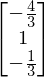

In [151]:
A.solve(b)

CPU times: user 2.42 ms, sys: 361 µs, total: 2.78 ms
Wall time: 2.71 ms


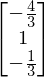

In [152]:
%%time
A.solve(b)

In [153]:
type(A[0,0])

sympy.core.numbers.One

In [154]:
type(1)

int

In [155]:
A[0,0]/2

We can repeat the solution using `numpy`:

In [156]:
import numpy

In [157]:
A = numpy.matrix([[1, 1, -1],
                  [2, 1, 1],
                  [1, -1, -1]])
b = numpy.matrix([[0, -2, -2]]).T

In [158]:
numpy.linalg.solve(A, b)

matrix([[-1.33333333],
        [ 1.        ],
        [-0.33333333]])

In [159]:
%%time
numpy.linalg.solve(A, b)

CPU times: user 138 µs, sys: 32 µs, total: 170 µs
Wall time: 149 µs


matrix([[-1.33333333],
        [ 1.        ],
        [-0.33333333]])

The numpy version is much faster.

In [166]:
N = 100
bigA = numpy.random.random((N, N))

In [167]:
bigb = numpy.random.random((N,))

In [168]:
%%timeit
numpy.linalg.solve(bigA, bigb)

10000 loops, best of 3: 148 µs per loop


In [171]:
bigsymbolicA = sympy.Matrix(bigA)

In [173]:
bigsymbolicA[0,0]

In [174]:
bigA[0,0]

In [175]:
bigsimbolicb = sympy.Matrix(bigb)

In [176]:
%%timeit
bigsymbolicA.solve(bigsimbolicb)

1 loop, best of 3: 19.4 s per loop


Nonlinear equations
===================

In some cases, sympy can solve nonlinear equations as well:

In [179]:
x, y = sympy.symbols('x, y')

In [180]:
sympy.solve([x + sympy.log(y), y**2 - 1], [x, y])

But sometimes nonlinear equations don't admit a closed-form solution:

In [181]:
unsolvable = x + sympy.cos(x) + sympy.log(x)
sympy.solve(unsolvable, x)

NotImplementedError: multiple generators [x, cos(x), log(x)]
No algorithms are implemented to solve equation x + log(x) + cos(x)

In such cases we need to use approximate solutions.

In [182]:
import scipy.optimize

In [183]:
unsolvable_numeric = sympy.lambdify(x, unsolvable)

In [185]:
unsolvable_numeric(50)

In [186]:
scipy.optimize.fsolve(unsolvable_numeric, 0.1)

array([ 0.28751828])

`fsolve` works for multiple equations as well, just return a list:

In [187]:
def multiple_equations(unknowns):
    x, y = unknowns
    return [x + y - 1,
            x - y]

In [188]:
multiple_equations([1, 2])

In [191]:
%%timeit
first_guess = [1, 1]
scipy.optimize.fsolve(multiple_equations, first_guess)

10000 loops, best of 3: 54.1 µs per loop


Remember the downsides of numerical solution:

1. Approximate rather than exact
2. Requires an initial guess
3. Slower to solve the equation every time rather than solving it once and then substituting values.
4. Typically only finds one solution, even if there are many.

Differential equations
======================

Now for differential equations. Sympy can solve some differential equations analytically:

We'll solve the "classic" tank problem:

$$\begin{align}
F_{out} &= kh\\
\frac{\mathrm{d}h}{\mathrm{d}t} &= \frac{1}{A}\left(F_{in} - F_{out}\right)\\
\end{align}
$$


In [213]:
h = sympy.Function('h')
t = sympy.Symbol('t', positive=True)

In [218]:
Fin = 2
K = 1
A = 1

In [219]:
Fout = K*h(t)

In [220]:
de = h(t).diff(t) - 1/A*(Fin - Fout)

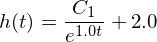

In [221]:
sympy.dsolve(de, ivs={h(0): 1})

We can also solve them numerically usinc `odeint`:

In [197]:
K = 2

In [199]:
def dhdt(h):
    Fout = K*h
    return 1/A*(Fin - Fout)

In [200]:
import scipy.integrate

In [201]:
ts = numpy.linspace(0, 10)

In [202]:
scipy.integrate.odeint(dhdt, ts, 1)

array([[  0.        ,   0.20408163,   0.40816327,   0.6122449 ,
          0.81632653,   1.02040816,   1.2244898 ,   1.42857143,
          1.63265306,   1.83673469,   2.04081633,   2.24489796,
          2.44897959,   2.65306122,   2.85714286,   3.06122449,
          3.26530612,   3.46938776,   3.67346939,   3.87755102,
          4.08163265,   4.28571429,   4.48979592,   4.69387755,
          4.89795918,   5.10204082,   5.30612245,   5.51020408,
          5.71428571,   5.91836735,   6.12244898,   6.32653061,
          6.53061224,   6.73469388,   6.93877551,   7.14285714,
          7.34693878,   7.55102041,   7.75510204,   7.95918367,
          8.16326531,   8.36734694,   8.57142857,   8.7755102 ,
          8.97959184,   9.18367347,   9.3877551 ,   9.59183673,
          9.79591837,  10.        ]])